# Исследование компьютерных игр

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### 0. Служебные функци для быстрого строительства графиков

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer 
import re
import seaborn as sns
from scipy import stats as st

en_stemmer = SnowballStemmer('english')
 
g = 0
def myhist(b, x,xl):
    global g
    g+=1
    ax=plt.gca()
    sns.distplot(x,bins=b, label = xl)
    ax.set_xlabel(xl)
    ax.set_ylabel('частота')
    ax.set_title(f'Гистограмма {g}: ' + xl) 
b=0
def mybox(x, yl, h, r):
    global b
    b+=1    
    plt.title(f'Диаграмма размаха {b}: ' + yl)
    plt.xlim(r)
    plt.ylabel(yl)
    plt.boxplot(x, vert=h)

<div class="alert alert-success">
<h2> Комментарии от ревьюера, проверка №1</h2>
    
Серьезный подход, я бы даже сказал основательный
</div>

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [37]:
df = pd.read_csv('/datasets/games.csv')
df.head() 

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Описание данных

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


##  Шаг 2. Подготовьте данные

### Заменим названия столбцов

In [39]:
df.columns = [x.lower() for x in df.columns]

### Преобразование данных
Преобразуем данные у user_score.

In [40]:
df.user_score.value_counts(dropna = False)

NaN    6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1.1       2
1.5       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

Больше 9000 данных отсутствуют - либо их оценил никто (NaN), либо очень мало человек - tbd. Так как данных 55%, то мы не можем их как-то заполнить.

### Обработка пропусков

Посмотрим на 2 noname игры

In [41]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


О них особо ничего нельзя сказать, особенно о последней. Смело удаляем эти игры. Их можно было бы оставить, имей они хоть жанр. Предположительно род ошибки - человеческий фактор. Ну и программный недосмотр - не стоит иметь возможность вносить такие игры в список.

In [42]:
df = df[df['name'].notnull()]

Рейтинг мало где известен, поэтому пропуски заполним 'unknow'.

In [45]:
df['rating'] = df['rating'].fillna('unknow')

Посмотрим на игры с незаполненым годом выпуска.

In [47]:
df.loc[df['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,unknow
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,unknow
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,unknow


Мы видим, что зачастую в названиях фигурирует год выпуска игры, воспользуемся этим

In [48]:
def year_extract(x):
    year =  re.findall(r'\d{4}',x)
    if year !=[]:
        return int(''.join(year))
    else:
        return np.nan

In [52]:
df.loc[df['year_of_release'].isnull(), 'year_of_release'] = df.loc[df['year_of_release'].isnull(), 'name'].apply(year_extract)
len(df.loc[df['year_of_release'].isnull()])

252

In [53]:
df = df.loc[df['year_of_release'].notnull()]

In [54]:
df['year_of_release'] = df['year_of_release'].astype('int')

Оценку критиков не стоит заполнять, так как у нас нет предпосылок к их заполнению. Заполним поле общих продаж

In [55]:
df['sales'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknow,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknow,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknow,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknow,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknow,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknow,0.01


## Шаг 3. Проведите исследовательский анализ данных
### Продажи по годам
Посмотрим, как продавались игры в разные годы.

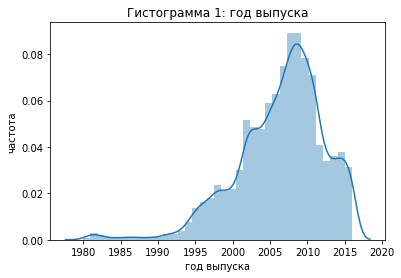

In [56]:
myhist(37, df.loc[df['year_of_release'].notnull(), 'year_of_release'], 'год выпуска')

Особо прибыльными для интернет магазина становились года с 2005 по 2011. Резкое падение в 2012 году. С него и стоит анализировать данные, так как успешные года будут искажать картину. Но, для начала, посмотрим на исторические данные:

In [57]:
ys = df.groupby(['year_of_release'])['sales'].sum().reset_index()
ps = df.groupby(['platform'])['sales'].sum().reset_index()
ps = ps.loc[(ps['sales']>300)].reset_index().sort_values('sales', ascending=False)
ps
ysp = df.groupby(['year_of_release','platform' ])['sales'].sum().reset_index()
ps

,index,platform,sales
3,16,PS2,1247.28
7,28,X360,961.30
4,17,PS3,931.34
6,26,Wii,891.18
0,4,DS,802.79
2,15,PS,727.58
5,18,PS4,314.14
1,6,GBA,312.88


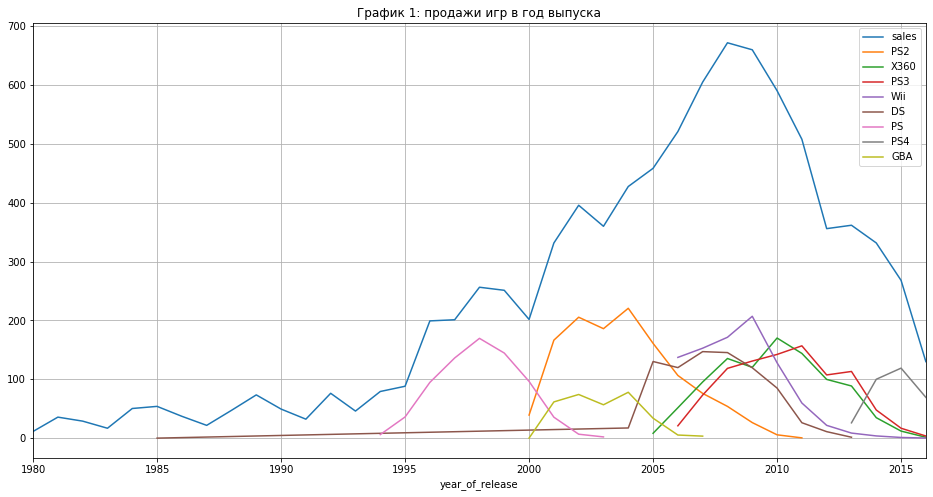

In [58]:
ax=ys.sort_values('year_of_release').plot(x='year_of_release', y='sales',grid=True,figsize=(16, 8), title = f'График {1}: зависимости цены от удалённости от центра')
ysp = df.groupby(['year_of_release','platform' ])['sales'].sum().reset_index()
gn=1
t = f'График {gn}: продажи игр в год выпуска'

for platf in ps['platform']:
    ysp.loc[ysp['platform'] == platf].sort_values('year_of_release').plot(x='year_of_release', y='sales', label = platf,grid=True,figsize=(16, 8),ax=ax, title = t)


По получившимся графикам видно, что популярность продаж игр на успешные платформы, в основном, следует следующему патерну: после появление платформы продажи игр идут вверх примерно 5 лет. Потом, примерно 5 лет покупательский интерес также идет на спад. Но, в нынешние годины угасания продаж видим, что для PS4 продажи шли вверх только 2,5 года. Такое уже бывало: для PS2 в 2004 году, когда продажи в целом шли вниз, они также и утянули пик продаж, поэтому график получился с двумя пиками, вместо одного. Такая же картина для приставки GBA в тех же временных рамках. Что же с PS4 - угасание покупательского интереса в связи с ситуацией в целом, или скорость развития технологий увеличилась - оба варианта имеют место быть.

Посмотрим на популярнейшие платформы с 2012 года, если  судить по продажам. Помотрим и на самые молодые платформы.

<div class="alert alert-success">
<h2> Комментарии от ревьюера, проверка №1</h2>
    
Согласен 
</div>

In [15]:
ps = df.loc[df['year_of_release']>=2012].groupby(['platform'])['sales'].sum().reset_index()
ps = ps.loc[(ps['sales']>50)].reset_index().sort_values('sales', ascending=False)
top_platforms = ps['platform'].tolist()
ps

,index,platform,sales
3,4,PS4,314.14
2,3,PS3,288.79
5,9,X360,236.54
0,0,3DS,194.61
6,10,XOne,159.32
4,8,WiiU,82.19
1,2,PC,62.65


<div class="alert alert-success">
<h2> Комментарии от ревьюера, проверка №1</h2>
    
Очень граммотная логика выше и молодец, что сделал правильный вывод на счет того, что нужно смотреть на платформы расстущие последние 203 года
</div>

In [23]:
df.groupby('platform')['year_of_release'].agg('min').sort_values()

platform
2600    1980
NES     1983
DS      1985
PC      1985
GB      1988
SNES    1990
GEN     1990
GG      1992
SCD     1993
NG      1993
SAT     1994
PS      1994
3DO     1994
TG16    1995
PCFX    1996
N64     1996
DC      1998
WS      1999
GBA     2000
XB      2000
PS2     2000
GC      2001
PSP     2004
X360    2005
PS3     2006
Wii     2006
3DS     2011
PSV     2011
WiiU    2012
PS4     2013
XOne    2013
Name: year_of_release, dtype: int64

Самые молодые в нашем магазине уже и так одни из самых популярных, поэтому нечего перспективного и не добавить.

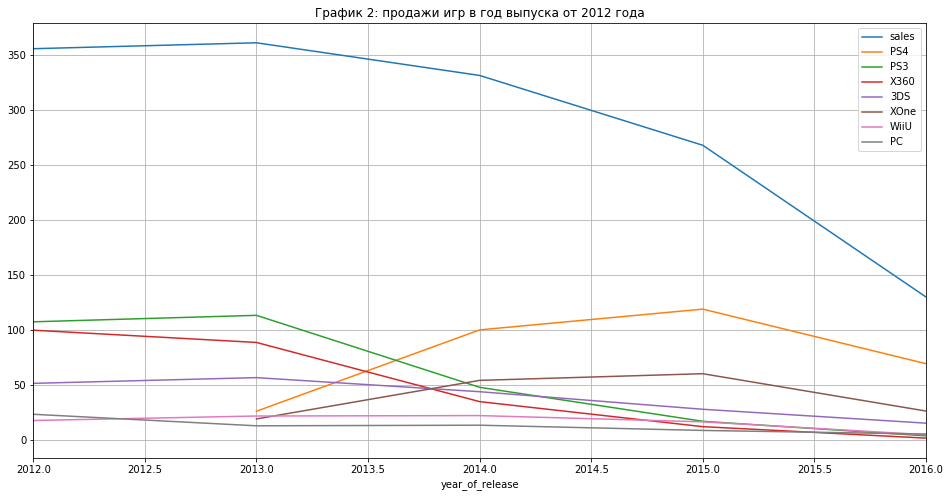

In [24]:
gn+=1
t = f'График {gn}: продажи игр в год выпуска от 2012 года'
ax=ys.loc[ys['year_of_release']>=2012].sort_values('year_of_release').plot(x='year_of_release', y='sales',grid=True,figsize=(16, 8), title = t)
ysp = df.groupby(['year_of_release','platform' ])['sales'].sum().reset_index()



for platf in ps['platform']:
    ysp.loc[(ysp['year_of_release']>=2012)&(ysp['platform'] == platf)].sort_values('year_of_release').plot(x='year_of_release', y='sales',label = platf, grid=True,figsize=(16, 8),ax=ax, title = t)

   

In [20]:
df.loc[df['year_of_release']>=2015].groupby(['platform'])['sales'].sum().reset_index().sort_values('sales', ascending=False).style.bar()

,platform,sales
3,PS4,188.15
9,XOne,86.29
0,3DS,42.92
7,WiiU,20.95
2,PS3,20.42
1,PC,13.77
8,X360,13.48
5,PSV,10.5
6,Wii,1.32
4,PSP,0.12


Судя по графику и по следующей за ним таблицей очевидно, что самые перспективные платфоры: PS4, XOne, 3DS. Причем продажи первых двух могут еще расти (их пик, видимо, "украл" общий спад продаж).

Построем график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

(-0.5, 6.5)

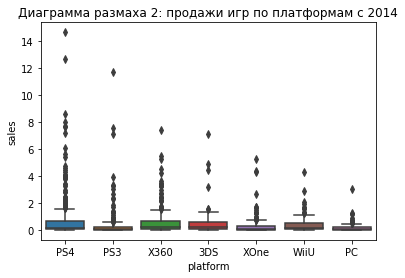

In [21]:
fig, ax = plt.subplots()
df_new =  df.loc[(df['year_of_release']>=2012)]

df_2014=df.loc[(df['year_of_release']>=2014)]

b+=1
ax = sns.boxplot(x="platform", y="sales", data=df_2014[df_2014.platform.isin(top_platforms)])
ax.set_title(f'Диаграмма размаха {b}: продажи игр по платформам c 2014')
ax.set_xticklabels(ps['platform'])
ax.set_xlim(xmin=-0.5)

У PS4 случаются анамольно высокие продажи. Рассмотрим поближе сами ящики.

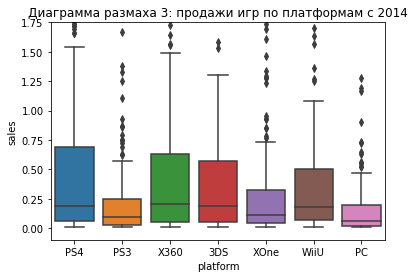

In [22]:
b+=1
ax = sns.boxplot(x="platform", y="sales", data=df_2014[df_2014.platform.isin(top_platforms)])
ax.set_title(f'Диаграмма размаха {b}: продажи игр по платформам c 2014')
ax.set_xticklabels(ps['platform'])
ax.set_xlim(xmin=-0.5)
ax.set_ylim(ymin=-0.1, ymax=1.75)

plt.show()


У лидирующих трех платформ продажи скошены вправо, что говорит о выгодности вкладывать именно в эти 2 платформы. 3DS имеет гораздо меньшую скошенность. Медианна у всех платформ примерно на одном уровне.

### Продажи и рейтинги

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

Матрица диаграмм рассеяния и таблица корреляции 1: пользовательский рейтинг, рейтинг критиков, продажи
              critic_score     sales  user_score
critic_score      1.000000  0.308197    0.517727
sales             0.308197  1.000000    0.004429
user_score        0.517727  0.004429    1.000000


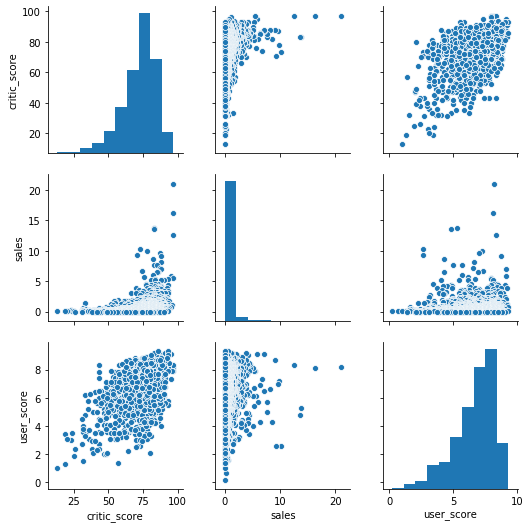

In [23]:
df_matrix = df_new.pivot_table(index=df_new.index, values=['sales','critic_score','user_score']) 

sns_plot = sns.pairplot(df_matrix)
sns_plot.savefig('pairplot.png')
m = 1
print(f'Матрица диаграмм рассеяния и таблица корреляции {m}: пользовательский рейтинг, рейтинг критиков, продажи')
print(df_matrix.corr()) 

Между отзывами критиков и пользователей есть неплохая корреляция. Продажи немного коррелируют с отзывами критиков. Предполагаю, что на продажи не влияют оценки пользователей, так как они считаются без учета "угасающего среднего" (см. шаг 2). 

### Продажи и жанры

Посмотрим на общее распределение игр по жанрам

In [24]:
df_gn = df_new.groupby(['genre'])['sales'].sum().reset_index().sort_values('sales', ascending=False)
df_gn.style.bar()

,genre,sales
0,Action,441.12
8,Shooter,304.73
7,Role-Playing,192.8
10,Sports,181.07
3,Misc,85.04
4,Platform,61
6,Racing,53.5
2,Fighting,44.49
9,Simulation,35.12
1,Adventure,29.43


Text(0.5, 1.0, 'Скрипичная диаграмма 1: Зависимость продаж от жанра')

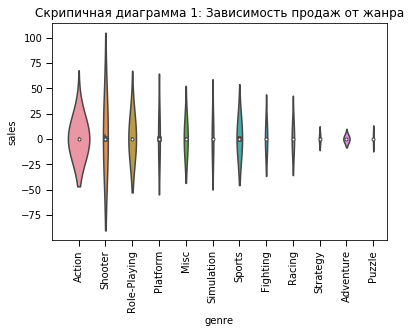

In [25]:
ax = sns.violinplot(x="genre", y="sales", data=df_new, scale="count",bw =20 )
ax.set_xlim(xmin=-1)
ax.tick_params(direction='out', length=6, width=1)
plt.xticks(rotation=90)
ax.set_title('Скрипичная диаграмма 1: Зависимость продаж от жанра')

Есть более прибыльные жанры, есть совсем не продающиеся. 

Самые прибльные Action и Shooter. При этом первые более однородны - продажи стремятся к медиане. Стрелялки очень не ровные - от супер-прибыльных до супер-провальных.

Самые непопулярные жанры: стратегии и пазлы.

## Шаг 4. Составьте портрет пользователя каждого региона
### Платформы
Определим для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5)

In [26]:
region = ['na_sales','eu_sales','jp_sales']
top_platform_reg = df_new.groupby('platform')['na_sales'].sum().reset_index().sort_values('na_sales', ascending=False).reset_index()[['platform','na_sales']]
for r in ['eu_sales','jp_sales']:
    dfr = df_new.groupby(['platform'])[r].sum().reset_index().sort_values(r, ascending=False).reset_index()[['platform', r]]
    top_platform_reg=top_platform_reg.merge(dfr, on='platform', how='outer')
top_platform_reg = top_platform_reg.set_index('platform')

In [27]:
top_platform_reg

,na_sales,eu_sales,jp_sales
platform,,,
X360,140.05,74.52,1.57
PS4,108.74,141.09,15.96
PS3,103.38,106.86,35.29
XOne,93.12,51.59,0.34
3DS,55.31,42.64,87.79
WiiU,38.10,25.13,13.01
PC,19.12,37.76,0.00
Wii,17.45,11.92,3.39
PSV,10.98,11.36,21.04


Text(0.5, 1, 'Тепловая карта 1: Региональные продажи и платформы')

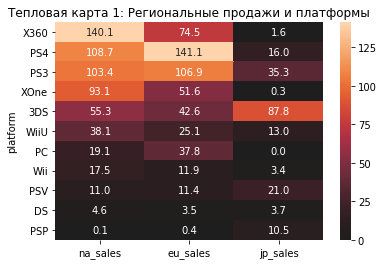

In [29]:
tn = 1
ax = sns.heatmap(top_platform_reg, annot=True, fmt=".1f", center = True)
ax.set_title(f'Тепловая карта {tn}: Региональные продажи и платформы')

<div class="alert alert-success">
<h2> Комментарии от ревьюера, проверка №1</h2>
    
Подход очень интересный и сложный и в итоге получаются очень подробные результаты
    
Честно, я не знаю насколько это тут обосновано, я бы ограничился просто круговой диаграммой по странам и жанрам
</div>

Интересные данные получились. В NA первое место Х360, когда в EU лидирует PS 4 и 3 поколения, потом уже идет Х360, в остальном 5-ка та же. JP все совсем иначе: 3DS лидирует, PSV идет следом - это портативные игровые системы. Х360 в петерку не входит, из стационарных представлены PS (более старая популярнее) и замыкает еще одна портативная WiiU.
### Жанры
Посмотрим на самые популярные жанры.

In [30]:
top_genre_reg = df_new.groupby('genre')['na_sales'].sum().reset_index().sort_values('na_sales', ascending=False).reset_index()[['genre','na_sales']]
for r in ['eu_sales','jp_sales']:
    dfr = df_new.groupby(['genre'])[r].sum().reset_index().sort_values(r, ascending=False).reset_index()[['genre', r]]
    top_genre_reg=top_genre_reg.merge(dfr, on='genre', how='outer')
top_genre_reg = top_genre_reg.set_index('genre')

Text(0.5, 1, 'Тепловая карта 2: Региональные продажи и жанры')

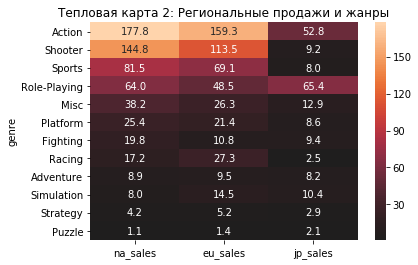

In [31]:
ax =sns.heatmap(top_genre_reg, annot=True, fmt=".1f", center = True)
tn += 1
ax.set_title(f'Тепловая карта {tn}: Региональные продажи и жанры')

In [32]:
df_new.groupby('genre')['jp_sales'].sum().reset_index().sort_values('jp_sales', ascending=False).reset_index()[['genre','jp_sales']].head()

,genre,jp_sales
0,Role-Playing,65.44
1,Action,52.80
2,Misc,12.86
3,Simulation,10.41
4,Fighting,9.44


В Америке и Европе все похоже Action, Shooter, Sports, Role-Playng. Последнии позиции в топ-5 различаются - в Америке это жанр разное, в Европе - гонки. В Японии все совсем по-другому. Схожа популярность Action (2е место в Японии). Можно пояснить популярностью портативных платформ.
### Рейтинг ESRB
Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

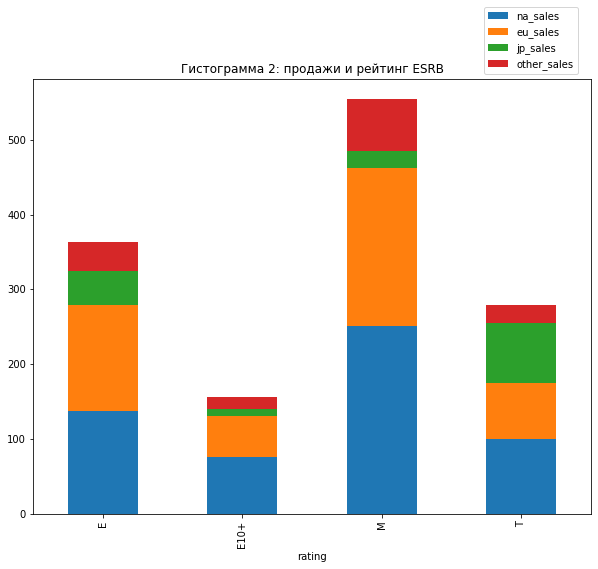

Text(0.5, 1, 'Тепловая карта 3: продажи и рейтинг ESRB')

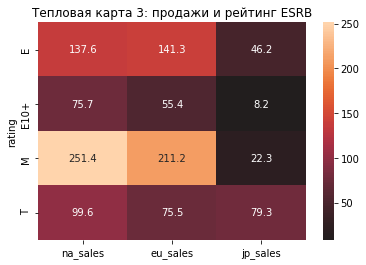

In [33]:
ax =  df_new.groupby(['rating'])['na_sales','eu_sales','jp_sales', 'other_sales'].sum().plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
g+=1
ax.set_title(f'Гистограмма {g}: продажи и рейтинг ESRB')
plt.show()
rat_sales = df_new.groupby(['rating'])['na_sales','eu_sales','jp_sales'].sum().reset_index()
rat_sales = rat_sales.set_index('rating')
ax =sns.heatmap(rat_sales, annot=True, fmt=".1f", center = True)
tn += 1
ax.set_title(f'Тепловая карта {tn}: продажи и рейтинг ESRB')

Из графиков опять видна "японская особенность": игры для тинейджеров гораздо популярнее, чем в Америке и Европе в процентном соотношении. А игры для взрослых, напротив, проигрывают.
### Слова

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


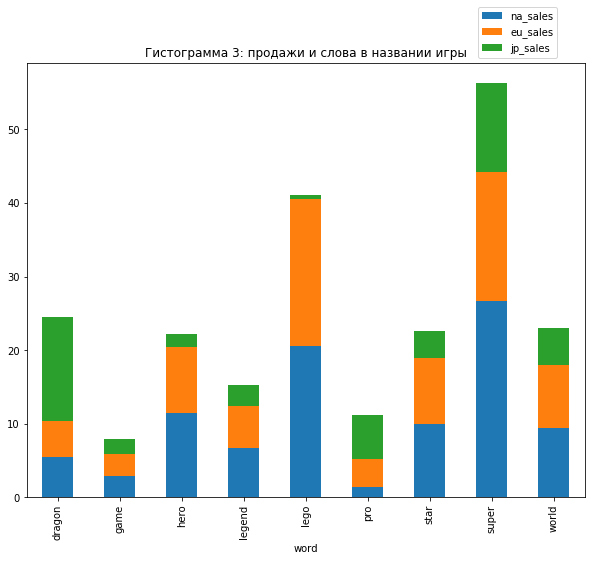

,index,word
0,lego,84
1,world,65
2,super,62
3,pro,62
4,star,59
5,dragon,56
6,game,55
7,legend,53
8,hero,52


In [34]:
nonsens = ['the', 'of', 'no', 'to', 'and', ' ', 'in', 'for', '' ]
def My_stem(queries):
    stl = []
    for query in queries:
        for word in query.split(' '):           
            stemmed_word = en_stemmer.stem(word)
            stemmed_word = re.sub(r'[^\D]|[^\w]','',stemmed_word)
            if (stemmed_word not in nonsens) and (stemmed_word!= ''):        
                stl.append(stemmed_word)
            
    return stl
def My_stem2(queries):
    stl = []
    
    for word in queries.split(' '):           
        stemmed_word = en_stemmer.stem(word)
        stemmed_word = re.sub(r'[^\D]|[^\w]','',stemmed_word)
        if (stemmed_word in raz):
            stl.append(stemmed_word)
    if stl !=[]:
        return ''.join(stl)
    else:
        return ''

stf= My_stem(df_new.name)
st0 = pd.DataFrame(data=stf, columns=['words'])
st0 = st0.words.value_counts().reset_index()
st0 = st0.loc[st0['words'] >= 50]
raz = st0['index'].tolist()

df_new['stem_name'] = df_new.name.apply(My_stem2)
dict_genr = {}
for word in raz:
    genr = df_new.query('stem_name.str.contains(@word)')['genre'].value_counts().reset_index()['index'][0]
    dict_genr[word] = genr

for key, value in dict_genr.items():
    df_new.loc[(df_new['genre'].isnull())&(df_new['stem_name'].str.contains(key)),'genre'] = df_new.loc[(df['genre'].isnull())&(df_new['stem_name'].str.contains(key)),'genre'].fillna(value)
df_new.stem_name.unique()

word_sale = pd.DataFrame({'na_sales':[],'eu_sales':[],'jp_sales':[],'word':[]})
for word in raz:
    mat = df_new.loc[df_new['stem_name'].str.contains(word),['na_sales','eu_sales','jp_sales']]
    mat['word'] = word
    mat = mat[['na_sales','eu_sales','jp_sales','word']]
    word_sale = pd.concat([word_sale, mat])

ax =  word_sale.groupby(['word'])['na_sales','eu_sales','jp_sales'].sum().plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
g+=1
ax.set_title(f'Гистограмма {g}: продажи и слова в названии игры')
plt.show()
word_sale.word.value_counts().reset_index().style.bar()

Самое продающее слово - super, затем идет слово lego, совсем не популярное в Японии. Инетерсно, что игр со словом lego в названии физически больше, но все равно лидирует super. Замыкает топ-3 драконы - их рейтинг делает Япония. Дышат в спину star, word и hero.

## Шаг 5. Проверьте гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC
Выдвигаем гипотезу, о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Используем гипотезу о равенстве средних для зависимых (парных) выборок. Парная выборка означает, что мы измеряем некоторую переменную для одних и тех же единиц. В нашем распоряжении измерения для пользователей одного оператора на 2-х тарифах.

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различны.

In [35]:
df_new.platform.value_counts()

PS3     493
PSV     411
3DS     396
PS4     392
X360    292
PC      250
XOne    247
PSP     173
WiiU    147
Wii      54
DS       31
Name: platform, dtype: int64

In [36]:
print('дисперсия XOne: ', np.var(df_new.query('(platform == "XOne")&(user_score.notnull())')['user_score']), \
      'дисперсия PC: ', np.var(df_new.query('(platform == "PC")&(user_score.notnull())')['user_score']))

дисперсия XOne:  1.8965188383045526 дисперсия PC:  2.7569952398906588


Так как у наших выборок разные дисперсии, то нам необходимо использовать t-критерий Уэлча

In [37]:
xbox_score = df_new.query('(platform == "XOne")&(user_score.notnull())')['user_score']
pc_score =df_new.query('(platform == "PC")&(user_score.notnull())')['user_score'].sample(n=len(df_new.query('(platform == "XOne")&(user_score.notnull())'))) 

In [38]:
pc_score_m = round(pc_score.mean(),2)
xbox_score_m =round(xbox_score.mean(),2)

alpha = .05 # критический уровень статистической значимости

print('cредние пользовательские рейтинги пользователей PC: ',pc_score_m)
print('cредние пользовательские рейтинги пользователей Xbox One: ',xbox_score_m)

results = st.ttest_ind(pc_score, xbox_score, equal_var = False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредние пользовательские рейтинги пользователей PC:  6.47
cредние пользовательские рейтинги пользователей Xbox One:  6.52
p-значение: 0.7317929217116024
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые. Альтернативная гипотеза: средние пользовательские рейтинги Action и Sports различны.

In [39]:
df_new.genre.value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

In [40]:
action_score = df_new.query('(genre == "Action")&(user_score.notnull())')['user_score'].sample(n=len(df_new.query('(genre == "Sports")&(user_score.notnull())'))) 
sports_score =df_new.query('(genre == "Sports")&(user_score.notnull())')['user_score']

In [42]:
print('дисперсия Action: ', np.var(df_new.query('(genre == "Action")&(user_score.notnull())')['user_score']), \
      'дисперсия Sports: ', np.var(df_new.query('(genre == "Sports")&(user_score.notnull())')['user_score']))

дисперсия Action:  1.8854720340439224 дисперсия Sports:  3.0073882971729127


In [43]:
action_score_m = round(action_score.mean(),2)
sports_score_m =round(sports_score.mean(),2)

print('cредние пользовательские рейтинги пользователей Action: ',action_score_m)
print('cредние пользовательские рейтинги пользователей Sports: ',sports_score_m)

results = st.ttest_ind(action_score, sports_score, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредние пользовательские рейтинги пользователей Action:  6.79
cредние пользовательские рейтинги пользователей Sports:  5.46
p-значение: 1.236815849759443e-15
Отвергаем нулевую гипотезу


## Вывод

Для магазина "Стримчик" золотая пора длилась с 2005 по 2012 годы - затем наступил резкий обвал продаж, в котором, по состоянию на 2016 год он и находится - поэтому анализировлся именно этот период. Популярность платформ менялась, среднее время популярности самых топовых из них около 5 лет, затем 5-летний спад. Свежая PS4 платформа достигла своего максимума за 2,5 года - это может объяснятся в целом спадом рынка, так и скоростью появлений новых технологий. Потенциально прибыльные платформы на основе анализа PS4, XOne, 3DS, WiiU. При этом 2 последнии из них - портативные системы, которые популярны в Японии.

Отзывы критиков имеют чуть большее влияние на продажи, чем отзывы пользователей. Предположим, что эти оценки не сбалансированы методом прибавления "затухающего среднего".
 
В Америке и Европе топ-3 популярных жанров одинаковы: Action, Shooter, Sports. В Японии все по-другому: Role-Playing, Action, Misc.

Что касается рейтинга ESRB опять видна "японская особенность": игры для тинеджеров гораздо популярнее, чем в Америке и Европе в процентном соотношении. А игры для взрослых, напротив, проигрывают.

Самое продающее слово в названии игры - super, затем идет слово lego, совсем не популярное в Японии. Замыкает топ-3 драконы - их рейтинг делает Япония. Дышат в спину star, word и hero.

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
